For a given time period averages rates between all of the sources and destinations and plots it.

In [1]:
%matplotlib inline
from datetime import datetime
import numpy as np
from elasticsearch import Elasticsearch, exceptions as es_exceptions
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
import datetime

In [2]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}])

In [3]:
#constants
searchString={
    "size":0,
    "query":{
        "filtered":{
            "query":{
                "query_string":{"query":"*","analyze_wildcard":True,"lowercase_expanded_terms":False}},
            "filter":{
                "range":{"timestamp":{"gte": 1459354970433,"lte": 1459369370433,"format": "epoch_millis"}}
            }
        }
    },
    "aggs": {"2":{"terms":{ "field":"source","size":80},
                  "aggs":{"3":{"terms":{"field":"destination","size":80},"aggs":{"1":{ "avg": { "field": "rate"}}}}}}}}

srcs = []
dests = []

Actually running the search

In [4]:
res= es.search(body=searchString)
print ('results returned in: ',res['took'], 'ms')
r=res['aggregations']['2']['buckets']
# print (r)
AllData={}
for s in r:
#     print ('source:', s['key'])
    srcs.append(s['key'])
    AllData[s['key']]={}
    tm=s['3']['buckets']
    for d in tm:
        if d['key'] not in dests:
            dests.append(d['key'])
        AllData[s['key']][d['key']]=d["1"]["value"]
#         print ('destination:',d['key'], d['doc_count'], d["1"]["value"])
print ("sources:", len(srcs), "destinations:",len(dests))
data=np.zeros( (len(srcs),len(dests)) )  
i=0
for s in srcs:
    j=0
    for d in dests:
        if d in AllData[s]:
            data[i,j]=AllData[s][d]
            if data[i,j]>30: data[i,j]=30
        j=j+1
    i=i+1

results returned in:  758 ms
sources: 61 destinations: 28


make heatmap plot

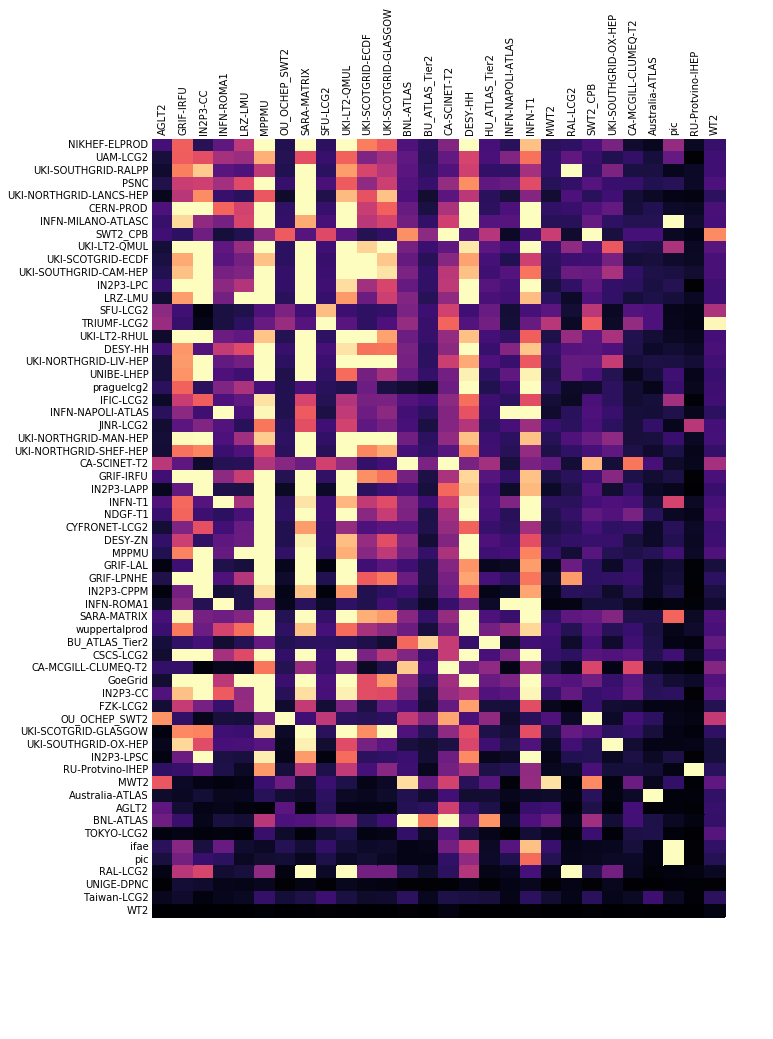

In [6]:
fig, ax = plt.subplots()
heatmap = ax.pcolor(data, cmap=plt.cm.magma)

# Format
fig = plt.gcf()
fig.set_size_inches(11, 16)

ax.set_yticks(np.arange(data.shape[0])+0.5, minor=False)
ax.set_xticks(np.arange(data.shape[1])+0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_yticklabels(srcs, minor=False)
ax.set_xticklabels(dests, minor=False)

plt.xticks(rotation=90)

# turn off the frame and all the ticks
ax.set_frame_on(False)
ax.grid(False)

# Turn off all the ticks
ax = plt.gca()
for t in ax.xaxis.get_major_ticks():
    t.tick1On = False
    t.tick2On = False
for t in ax.yaxis.get_major_ticks():
    t.tick1On = False
    t.tick2On = False